<a href="https://colab.research.google.com/github/avikumart/LLM-GenAI-Transformers-Notebooks/blob/main/TMLC_LLM_projects/AI_agents/HIL_LangGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Libraries

In [1]:
!pip install langgraph langchain_openai openai langchain_community tavily-python duckduckgo-search -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.2/150.2 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.0/55.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.2/413.2 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.3 MB/s eta 0:00:00


## Load Libraries

In [3]:
import os
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
os.environ['TAVILY_API_KEY'] = userdata.get('tavily')

In [4]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt

from langchain_community.tools import DuckDuckGoSearchRun

## Configure Agent

In [5]:
# Define a TypedDict for the state, with a list of messages annotated with 'add_messages'
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Initialize a StateGraph with the defined state type
graph_builder = StateGraph(State)

# Define a tool that uses DuckDuckGo to search the web
@tool
def DuckDuckGoSearch(query: str) -> str:
    """Use DuckDuckGo to search the web."""
    search = DuckDuckGoSearchRun()  # Create a DuckDuckGo search runner
    return search.invoke(query)  # Perform the search and return the result

# Define a tool to request human assistance for tool selection
@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human regarding which tool to select."""
    human_response = interrupt({"query": query})  # Send an interrupt with the query
    return human_response["data"]  # Return the human's response data

# Initialize a Tavily search tool with a maximum of 2 results
tavily_tool = TavilySearchResults(max_results=2)

# Define a list of tools available to the chatbot
tools = [tavily_tool, DuckDuckGoSearch, human_assistance]

# Create an instance of the language model with a specific configuration
llm = ChatOpenAI(model="gpt-4o-mini")

# Bind the tools to the language model
llm_with_tools = llm.bind_tools(tools)

# Define the chatbot function that processes messages using the language model and tools
def chatbot(state: State):
    # Invoke the language model with the current state messages
    message = llm_with_tools.invoke(state["messages"])
    # Ensure the model makes at most one tool call
    assert(len(message.tool_calls) <= 1)
    # Return the updated state with the new message
    return {"messages": [message]}

# Add the chatbot function as a node in the state graph
graph_builder.add_node("chatbot", chatbot)

# Create a ToolNode with the list of tools and add it to the graph
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# Add conditional edges from the chatbot node based on tool conditions
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,  # Define the conditions for tool execution
)

# Add a direct edge from the tools node to the chatbot node
graph_builder.add_edge("tools", "chatbot")

# Add a starting edge to the chatbot node
graph_builder.add_edge(START, "chatbot")

# Initialize a memory saver for the graph's checkpoints
memory = MemorySaver()

# Compile the state graph with the memory saver as the checkpointer
graph = graph_builder.compile(checkpointer=memory)

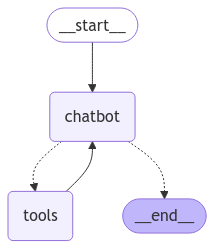

In [6]:
# Display graph
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

## Test Human in Loop

In [7]:
# Define user input for the agent
user_input = "When is the India vs England 1st T20i happening in 2025?"

# Configuration settings for the graph -> thread id
config = {"configurable": {"thread_id": "User_1"}}

# Stream events through the graph with the provided input and configuration
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},  # Initial user message
    config,  # Configuration details
    stream_mode="values",
)

# Iterate through the streamed events
for event in events:
    # Check if the event contains messages
    if "messages" in event:
        # Pretty-print the last message in the list of messages
        event["messages"][-1].pretty_print()

================================ Human Message =================================

When is the India vs England 1st T20i happening in 2025?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_Ma0RaPlGWr8T64dERzKIsbZa)
 Call ID: call_Ma0RaPlGWr8T64dERzKIsbZa
  Args:
    query: India vs England 1st T20I 2025 date
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.ndtvprofit.com/sports/india-vs-england-t20i-series-2025-date-time-venues-schedule-live-streaming-squads-and-more", "content": "India vs England T20I Series 2025: Date, Time, Venues, Schedule, Live Streaming, Squads And More View Premium Stories SportsIndia vs England T20I Series 2025: Date, Time, Venues, Schedule, Live Streaming, Squads And More India vs England T20I Series 2025: Date, Time, Venues, Schedule, Live Streaming, Squads And More NDTV Profit News India vs Engl

So for this question the model thought of calling the DuckDuckGo search without asking the human for help. Lets look at another example.

In [9]:
user_input = "I need help with creating code for configuring OpenAI keys?"
config = {"configurable": {"thread_id": "User_1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need help with creating code for configuring OpenAI keys?


BadRequestError: Error code: 400 - {'error': {'message': "An assistant message with 'tool_calls' must be followed by tool messages responding to each 'tool_call_id'. The following tool_call_ids did not have response messages: call_V69omNWc1a6YdFELdrEim2CL", 'type': 'invalid_request_error', 'param': 'messages.[6].role', 'code': None}}

In [10]:
# see where the graph is currently pointing at
snapshot = graph.get_state(config)
snapshot.next

('chatbot',)

In [11]:
human_response = (
    "Call Tavily"
)

human_command = Command(resume={"data": human_response}) # Send human response via Command function

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need help with creating code for configuring OpenAI keys?


BadRequestError: Error code: 400 - {'error': {'message': "An assistant message with 'tool_calls' must be followed by tool messages responding to each 'tool_call_id'. The following tool_call_ids did not have response messages: call_V69omNWc1a6YdFELdrEim2CL", 'type': 'invalid_request_error', 'param': 'messages.[6].role', 'code': None}}

So here we told model to use which tool, similarly could pass more details with the human message as well.